# Preliminary Settings

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# switch working directory to working directory of main repository 
os.chdir("./..")

In [2]:
from codes import *

reorganize_data()

Data already reorganized!


# Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data();

In [4]:
# example images
example_idx = {}
labels = np.unique(y_train)
for i in labels:
    example_idx[i] = np.where(y_train==i)[0][0]  # tinker with the last index value to experiment with different images

In [5]:
# function to plot example images
def plot_images(data, idx, channels):
    mapping = {0: "cell periphery", 1: "cytoplasm", 2: "endosome", 3: "er", 4: "golgi",
               5: "mitochondrion", 6: "nuclear periphery", 7: "nucleolus", 8: "nucleus",
               9: "peroxisome", 10: "spindle pole", 11: "vacuole"}
    fig, ax = plt.subplots(2,6, figsize=(12,5))
    if channels == 3:
        ax[0,0].imshow(cv2.cvtColor(data[idx[0]],cv2.COLOR_BGR2RGB))
        ax[0,0].set_title(mapping[0])
        ax[0,1].imshow(cv2.cvtColor(data[idx[1]],cv2.COLOR_BGR2RGB))
        ax[0,1].set_title(mapping[1])
        ax[0,2].imshow(cv2.cvtColor(data[idx[2]],cv2.COLOR_BGR2RGB))
        ax[0,2].set_title(mapping[2])
        ax[0,3].imshow(cv2.cvtColor(data[idx[3]],cv2.COLOR_BGR2RGB))
        ax[0,3].set_title(mapping[3])
        ax[0,4].imshow(cv2.cvtColor(data[idx[4]],cv2.COLOR_BGR2RGB))
        ax[0,4].set_title(mapping[4])
        ax[0,5].imshow(cv2.cvtColor(data[idx[5]],cv2.COLOR_BGR2RGB))
        ax[0,5].set_title(mapping[5])
        ax[1,0].imshow(cv2.cvtColor(data[idx[6]],cv2.COLOR_BGR2RGB))
        ax[1,0].set_title(mapping[6])
        ax[1,1].imshow(cv2.cvtColor(data[idx[7]],cv2.COLOR_BGR2RGB))
        ax[1,1].set_title(mapping[7])
        ax[1,2].imshow(cv2.cvtColor(data[idx[8]],cv2.COLOR_BGR2RGB))
        ax[1,2].set_title(mapping[8])
        ax[1,3].imshow(cv2.cvtColor(data[idx[9]],cv2.COLOR_BGR2RGB))
        ax[1,3].set_title(mapping[9])
        ax[1,4].imshow(cv2.cvtColor(data[idx[10]],cv2.COLOR_BGR2RGB))
        ax[1,4].set_title(mapping[10])
        ax[1,5].imshow(cv2.cvtColor(data[idx[11]],cv2.COLOR_BGR2RGB))
        ax[1,5].set_title(mapping[11])
    elif channels == 1:
        ax[0,0].imshow(data[idx[0]], cmap="gray")
        ax[0,0].set_title(mapping[0])
        ax[0,1].imshow(data[idx[1]], cmap="gray")
        ax[0,1].set_title(mapping[1])
        ax[0,2].imshow(data[idx[2]], cmap="gray")
        ax[0,2].set_title(mapping[2])
        ax[0,3].imshow(data[idx[3]], cmap="gray")
        ax[0,3].set_title(mapping[3])
        ax[0,4].imshow(data[idx[4]], cmap="gray")
        ax[0,4].set_title(mapping[4])
        ax[0,5].imshow(data[idx[5]], cmap="gray")
        ax[0,5].set_title(mapping[5])
        ax[1,0].imshow(data[idx[6]], cmap="gray")
        ax[1,0].set_title(mapping[6])
        ax[1,1].imshow(data[idx[7]], cmap="gray")
        ax[1,1].set_title(mapping[7])
        ax[1,2].imshow(data[idx[8]], cmap="gray")
        ax[1,2].set_title(mapping[8])
        ax[1,3].imshow(data[idx[9]], cmap="gray")
        ax[1,3].set_title(mapping[9])
        ax[1,4].imshow(data[idx[10]], cmap="gray")
        ax[1,4].set_title(mapping[10])
        ax[1,5].imshow(data[idx[11]], cmap="gray")
        ax[1,5].set_title(mapping[11])
    else:
        print("Number of channels should be either 1 or 3")

Here's how the original data looks like.

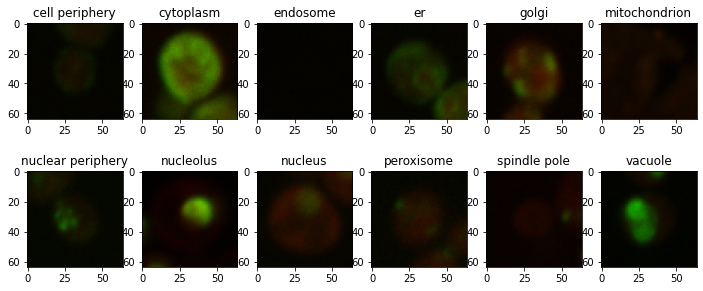

In [6]:
plot_images(X_train, example_idx, 3)

# Split Channels

In [7]:
# image preprocessing step
image_processor = image_preprocessing()

# preprocess train data
_ = image_processor.split_channels(X_train)
_,_ = image_processor.ROI()
Xn_train = image_processor.image_normalize(option="ROI")

# preprocess valid data
_ = image_processor.split_channels(X_valid)
_,_ = image_processor.ROI()
Xn_valid = image_processor.image_normalize(option="ROI")

# preprocess train data
_ = image_processor.split_channels(X_test)
_,_ = image_processor.ROI()
Xn_test = image_processor.image_normalize(option="ROI")

Here's how the normalized data look like.

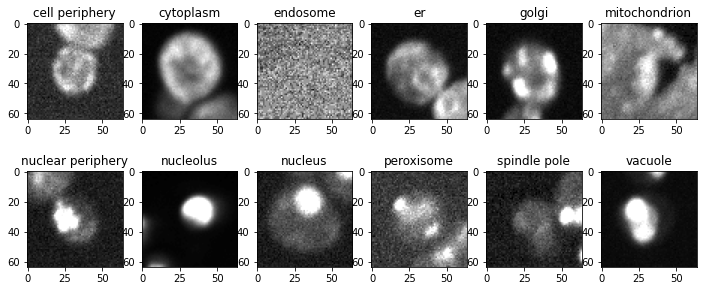

In [8]:
plot_images(Xn_train, example_idx, 1)

# Binary mask on Red Channel

# Crop ROI on Green Channel

# Feature Extraction

## Shift-Invariant Feature Transform (SIFT) for Bag of Feature (BoF)

In [9]:
sift_ = SIFT_FeatureExtractor()
Xsift_train = sift_.fit_transform(Xn_train)
Xsift_valid = sift_.transform(Xn_valid)

TypeError: image is not a numpy array, neither a scalar

In [ ]:
plot_images(Xsift_train, example_idx, 1)

## Local Discriminant Basis (LDB) using Wavelets Transform

Local Discriminant Basis is a feature extraction technique developed by N. Saito and R. Coifman in 1995. This algorithm follows the following basic steps:

1. Decompose a set of multi-class signals using wavelet packet decomposition. A wavelet packet decomposition decomposes a signal into multiple nodes which resembles a binary tree.
2. Based on the decomposed wavelet coefficients, build an energy map based on time-frequency or probability density.
3. Using the energy map, compute the discriminant measure and select a basis tree that best discriminates the different classes of signals.
4. Based on the selected basis tree, extract the corresponding wavelet coefficients for each signal.
5. Compute the discriminant power of each coefficient index. Select the top k set of coefficients to be used as features to be passed onto a classifier such as Linear Discriminant Analysis (LDA) and Classification and Regression Trees (CART).

A more in-depth tutorial can be found in the Pluto notebook [here](https://github.com/ShozenD/LDBExperiments). For more information on LDB, please refer to the original paper "Local Discriminant Basis and their Applications" by Saito and Coifman [here](https://www.math.ucdavis.edu/~saito/publications/saito_ldb_jmiv.pdf).

In [ ]:
from julia import Main

Main.using("Wavelets")
Main.using("WaveletsExt")

ldb_ = LDB_FeatureExtractor(wt=Main.wavelet(Main.WT.coif4), max_dec)
Xldb_train = ldb_.fit_transform(Xn_train)

View the best basis for the purpose of discriminating the different classes.

In [ ]:
Main.plot_tfbdry(ldb_.tree)

View the discriminant power plot, and use the elbow rule to determine the number of features to be used.

In [ ]:
plt.plot(np.arange(1,64**2+1), ldb_.DP[ldb_.order])
plt.title("Sorted discriminant power")

We decided that 100 is a fair amount of features to be extracted. So here we go...

In [ ]:
Xldb_train = ldb_.change_nfeatures(Xldb_train, 100)
Xldb_valid = ldb_.transform(Xn_valid)

## Stationary Wavelet Transform (SWT) Based Feature Extractor

**Note:** This method is referenced from Qayyum et al.'s "Facial Expression Recognition Using Stationary Wavelet Transform Features".

Another method of feature extraction is using stationary wavelet transforms (SWT). Unlike its wavelet transform counterpart, SWT does not perform downsampling, ie. the decomposed images have the exact same shape as the original signal. Therefore, the SWT is considered as a redundant transform. 

Since our images are decomposed into Approximation coefficients and Horizontal, Vertical and Diagonal coefficients, the total number of coefficients of the decomposed images is 4 times the number of the original image. The number of coefficients increases by a multiple of 4 if we decide to further decompose our image into more levels. For the sake of speed and efficiency, we will not pursue any decomposition beyond the first level.

**SWT for Image Classification**

For the purpose of image classification, incorporating SWT into our model means that we follow the steps below:

1. **1 level of SWT decomposition of each image.** As mentioned previously, we will only compute one level of decomposition for each image. This will lead to us obtaining the approximate (`cA`), horizontal detail (`cH`), vertical detail (`cV`), and diagonal detail (`cD`) coefficients.
2. **Compute the Discrete Cosine Transform (DCT) on each set of coefficients.** To reduce the size of feature coefficients, $8 \times 8$ block DCT is applied to the `cH`, `cV`, and `cD` coefficients only. Based on Qayyum et al's paper, the DCT applied to each block is calculated as
$$
X(u,v) = \frac{C(u) C(v)}{4} \sum_{m=0}{7} \sum_{n=0}{7} x[m,n] \cos(\frac{(2m+1)u\pi}{16}) \cos(\frac{(2n+1)v\pi}{16})
$$
where
$$
C(u) = \begin{cases} \frac{1}{\sqrt{2}}, & u=0 \\ 1, & 1\leq u \leq 7 \end{cases}, C(v) = \begin{cases} \frac{1}{\sqrt{2}}, & v=0 \\ 1, & 1\leq v \leq 7 \end{cases}
$$
This can be done using the `scipy.fftpack.dct` function and setting `type=2` and `norm="ortho"`.
3. **Reshape the results from step 2 into 1D vectors.**
4. **Fit the result from step 4 into a classifier.**

For the prediction step, we have the following pipeline:

1. **1 level of SWT decomposition of each image.**
2. **Compute the Discrete Cosine Transform (DCT) on each set of coefficients.**
3. **Reshape the results from step 2 into 1D vectors.**
4. **Fit the result from step 4 into a classifier.**

*Note: Interestingly, Qayyum et al did not use the approximation coefficients in the image classification process. Whether that can have some drastic effect remains to be seen. Maybe at the end of the day we apply SIFT on the approximation coefficients?*

**Pros:**

* SWT is shift invariant, which can be important when it comes to feature extraction in cell images.

**Cons:**

* Due to its redundant nature, the SWT is significantly less efficient that the DWT, and this may pose a problem with the large number of images that we have.

#### Stationary Wavelet Transform

Text(0.5, 1.0, 'Detail coef. (HH)')

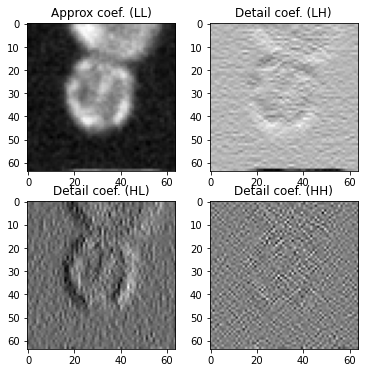

In [12]:
import pywt

# play around with the images and wavelets to observe the effect of SWT
# also try out with contrast-adjusted images
im = Xn_train[example_idx[0]]
wt = "Haar"

cA, (cH, cV, cD) = pywt.swt2(im, wt, 1, 0, trim_approx=True)

fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].imshow(cA, cmap="gray")
ax[0,0].set_title("Approx coef. (LL)")
ax[0,1].imshow(cH, cmap="gray")
ax[0,1].set_title("Detail coef. (LH)")
ax[1,0].imshow(cV, cmap="gray")
ax[1,0].set_title("Detail coef. (HL)")
ax[1,1].imshow(cD, cmap="gray")
ax[1,1].set_title("Detail coef. (HH)");

#### Discrete Cosine Transform

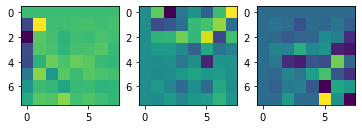

In [13]:
from scipy.fftpack import dct

result = []
for mat in [cH, cV, cD]:
    dmat = dct(dct(mat, 2, axis=0, norm="ortho"), 2, axis=1, norm="ortho")
    result += [dmat[::8, ::8]]

# plotting heatmap of results from DCT
fig, ax = plt.subplots(1,3)
ax[0].imshow(result[0])
ax[1].imshow(result[1])
ax[2].imshow(result[2])

In [ ]:
swt_ = SWT_FeatureExtractor(wt="coif4")
Xswt_train = swt_.fit_transform(Xn_train)

## Haralick texture features based on GLCM (gray level co-occurrence matrix)

## Speeded-up Robust Features (SURF) for Bag of Feature (BoF)

## Wavelets Scattering

# Dimension Reduction

# Model Fitting

## SIFT Based Model

## LDB Based Model

## SWT Based Model

## Haralick Based Model

## SURF Based Model

## Wavelets Scattering Based Model